# Precipitation

- Summary of precipitation projections over the Arctic ocean & sea-ice in UKESM1 SSP585
- Includes breakdown of snowfall vs rainfall
- Uses variables `pr`, `prsn` which are on the atmosphere lat-lon grid
- Uses `NSIDC_Regions_Masks_LatLon_nearest_s2d.nc` which can be generated in `regrid.ipynb`
- Base units: kg m-2 s-1 (= mm s-1)

### TODO

- [X] *Crop to Arctic ocean/sea-ice area*
- [X] Crop to SIE
- [ ] Think of better way to represent pr on sea ice, i.e. seeing less in 2080-2100 as less sea ice to hit
- [ ] Historical (1980-2015)
- [X] NSIDC regions
- [ ] CMIP6 ensemble
- [ ] Different grid?
- [ ] Multiple SSPs

## Imports & defaults

In [2]:
import libs.helpers as helpers
import libs.plot
import matplotlib
import numpy as np
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

import warnings
warnings.filterwarnings('ignore')

## Functions

## Data

In [3]:
path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_LatLon_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask
nsidc_mask = nsidc_mask.roll(x=96, roll_coords=True)

path_areacella = '_data/cmip6/UKESM1/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
areacella = xarray.open_mfdataset(paths=path_areacella, combine='by_coords').areacella

pr = helpers.get_data('ssp585', 'Amon', 'pr', 'r2i1p1f2').pr
prsn = helpers.get_data('ssp585', 'Amon', 'prsn', 'r2i1p1f2').prsn

pr = pr.where(pr.lat > 60).where(nsidc_mask.values > 0)
prsn = prsn.where(prsn.lat > 60).where(nsidc_mask.values > 0)
prra = pr - prsn

pr_arr = [
    {
        'data': pr,
        'label': 'Precipitation'
    },
    {
        'data': prsn,
        'label': 'Snowfall'
    },
    {
        'data': prra,
        'label': 'Rainfall'
    },
]

## Time series

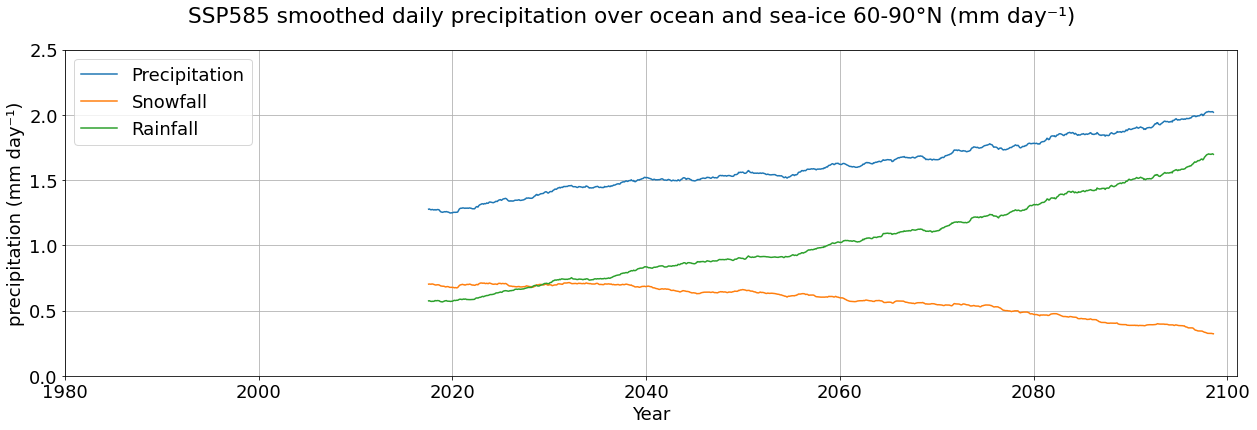

In [4]:
libs.plot.time_series(
    pr_arr,
    title='SSP585 smoothed monthly mean precipitation over ocean and sea-ice 60-90°N (mm day⁻¹)',
    xattr='time',
    ylabel='precipitation (mm day⁻¹)',
    yrange=[0, 2.5],
    process=lambda x: helpers.smoothed_mean(
        helpers.weighted(x * 86400).mean(dim=('lat', 'lon'), skipna=True)
    )
)

### Precipitation over sea-ice extent

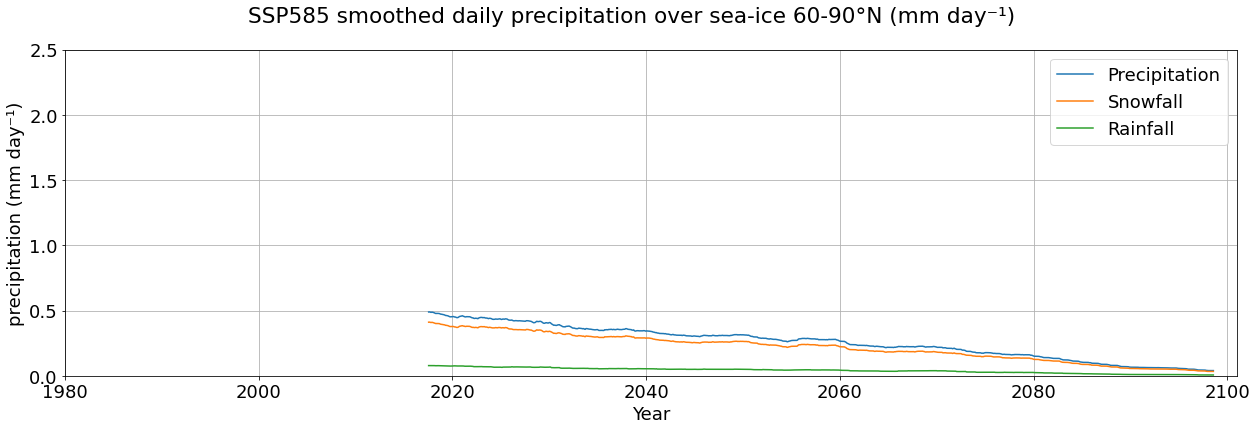

In [17]:
siconca_base = helpers.get_data('ssp585', 'SImon', 'siconca', 'r2i1p1f2')
siconca = siconca_base.siconca
siconca = siconca.where(siconca.lat > 60).where(nsidc_mask.values > 0)

pr_siconca_arr = [
    {
        'data': pr * siconca / 100,
        'label': 'Precipitation'
    },
    {
        'data': prsn * siconca / 100,
        'label': 'Snowfall'
    },
    {
        'data': prra * siconca / 100,
        'label': 'Rainfall'
    },
]

libs.plot.time_series(
    pr_siconca_arr,
    title='SSP585 smoothed monthly mean precipitation over sea-ice 60-90°N (mm day⁻¹)',
    xattr='time',
    ylabel='precipitation (mm day⁻¹)',
    yrange=[0, 2.5],
    process=lambda x: helpers.smoothed_mean(
        helpers.weighted(x * 86400).mean(dim=('lat', 'lon'), skipna=True)
    )
)

## Monthly variability (time)

### Full region

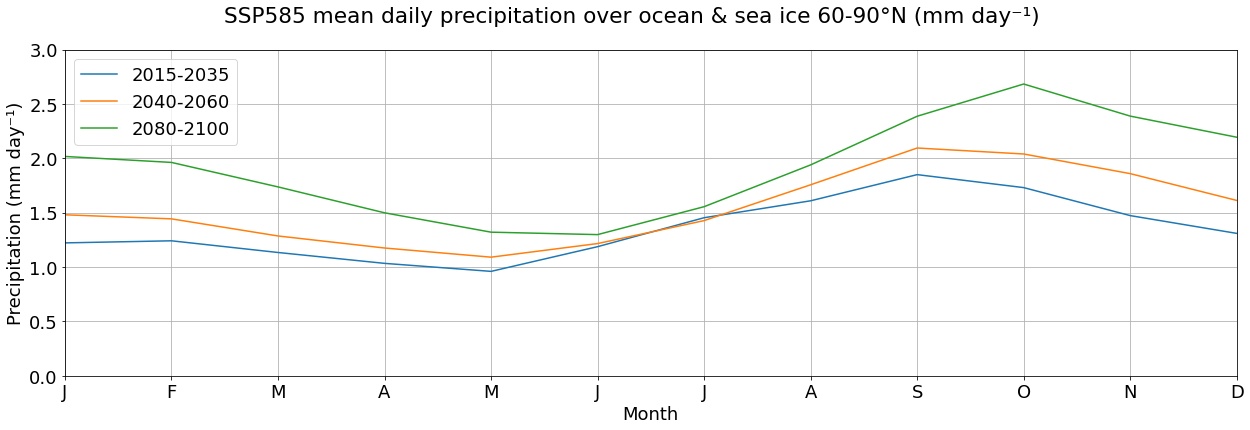

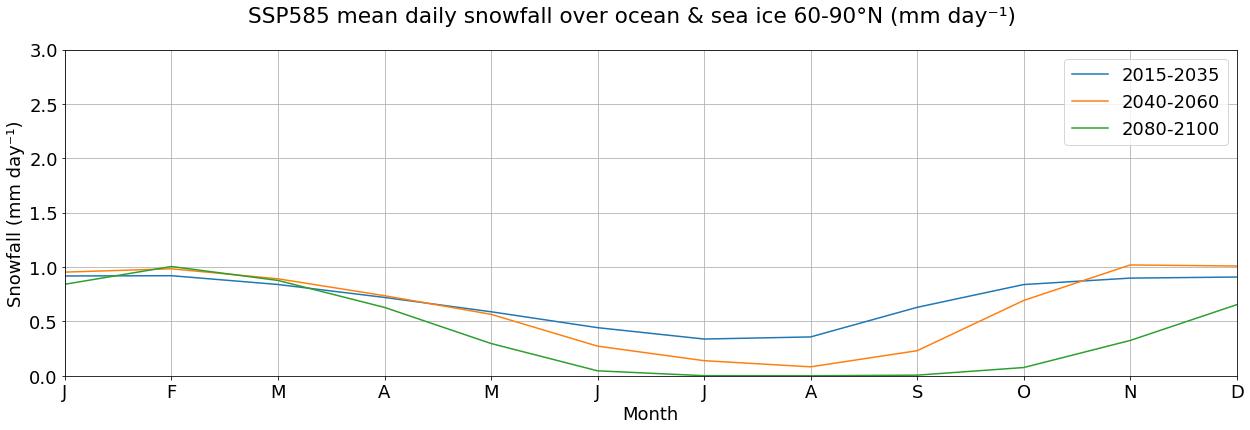

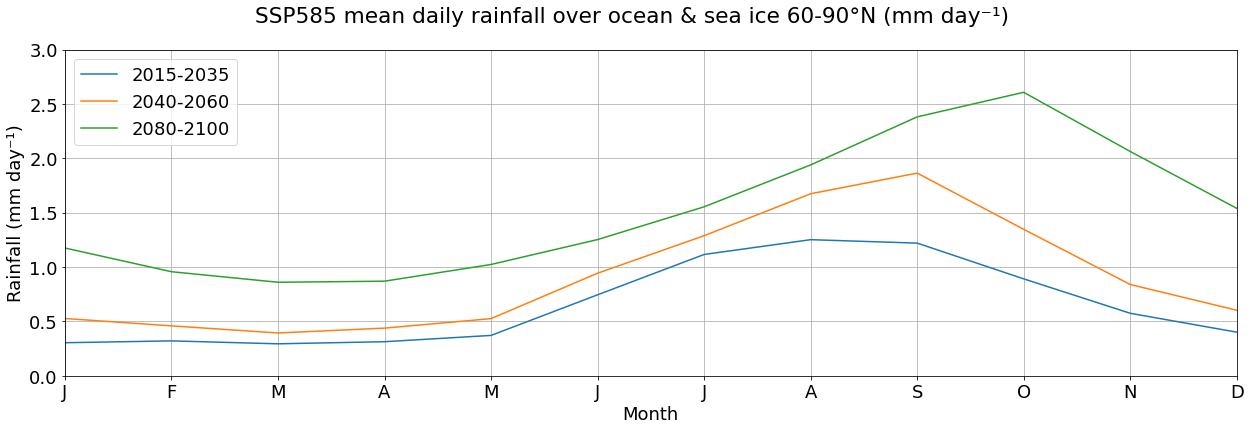

In [4]:
for item in pr_arr:
    data_mod = item['data'].copy()
    label = item['label']
    units = 'mm day⁻¹'
    
    libs.plot.monthly_variability(
        helpers.monthly_means_time(data_mod * 86400), # /s => /day
        title=f'SSP585 mean daily {(label).lower()} over ocean & sea ice 60-90°N ({units})',
        ylabel=f'{label} ({units})',
        yrange=[0, 3]
    )

### Sea-ice region

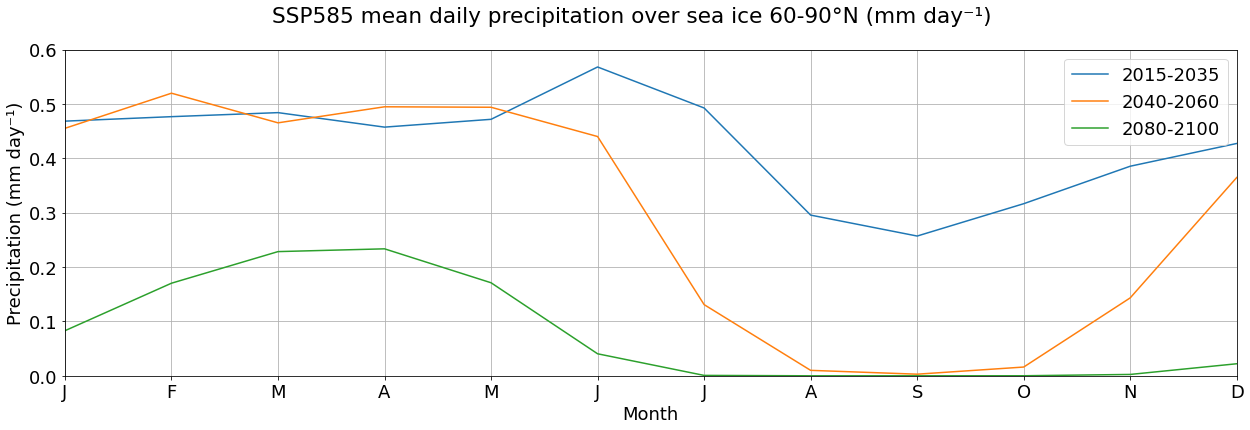

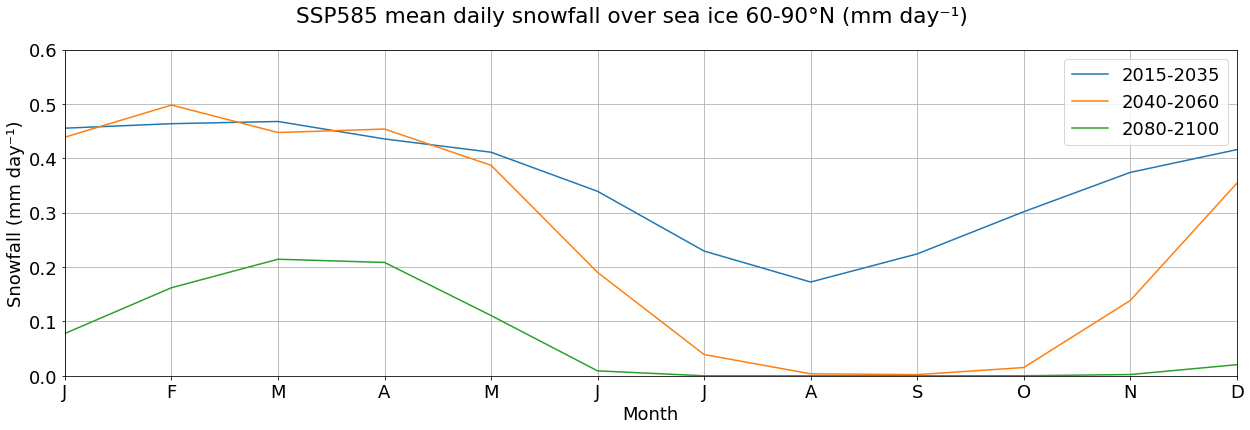

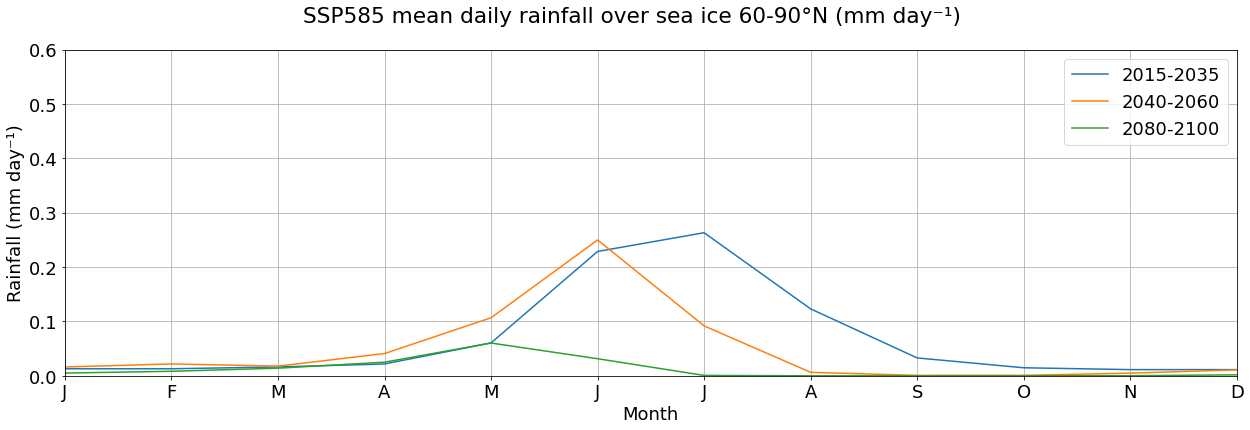

In [19]:
for item in pr_siconca_arr:
    data_mod = item['data'].copy()
    label = item['label']
    units = 'mm day⁻¹'
    
    libs.plot.monthly_variability(
        helpers.monthly_means_time(data_mod * 86400), # /s => /day
        title=f'SSP585 mean daily {(label).lower()} over sea ice 60-90°N ({units})',
        ylabel=f'{label} ({units})',
        yrange=[0, 0.6]
    )

### Regional precipitation

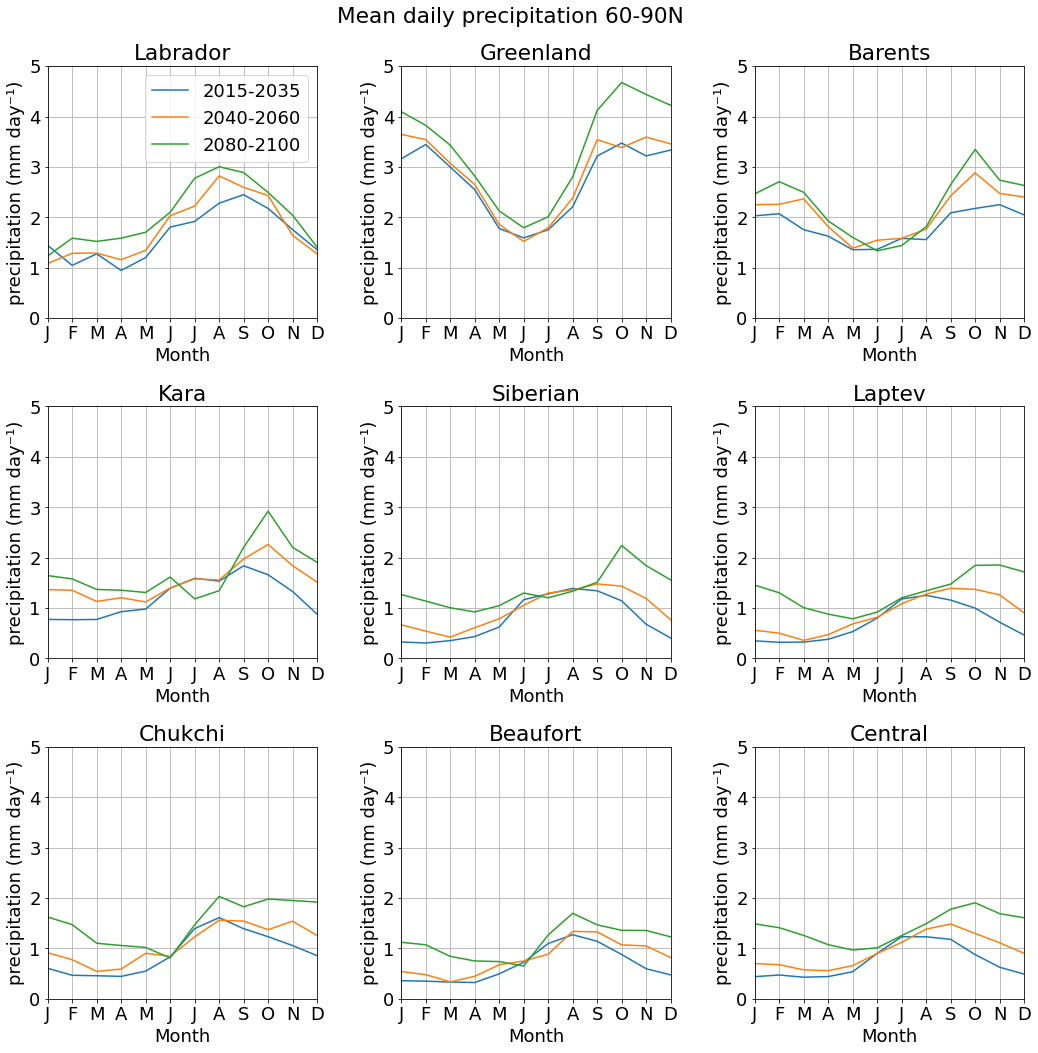

In [5]:
libs.plot.monthly_variability_regional(
    pr, 
    title='Mean daily precipitation 60-90N', 
    ylabel='precipitation (mm day⁻¹)',
    process=lambda x: helpers.monthly_means_time(x * 86400),
    ylim=[0, 5]
)

### Regional snowfall

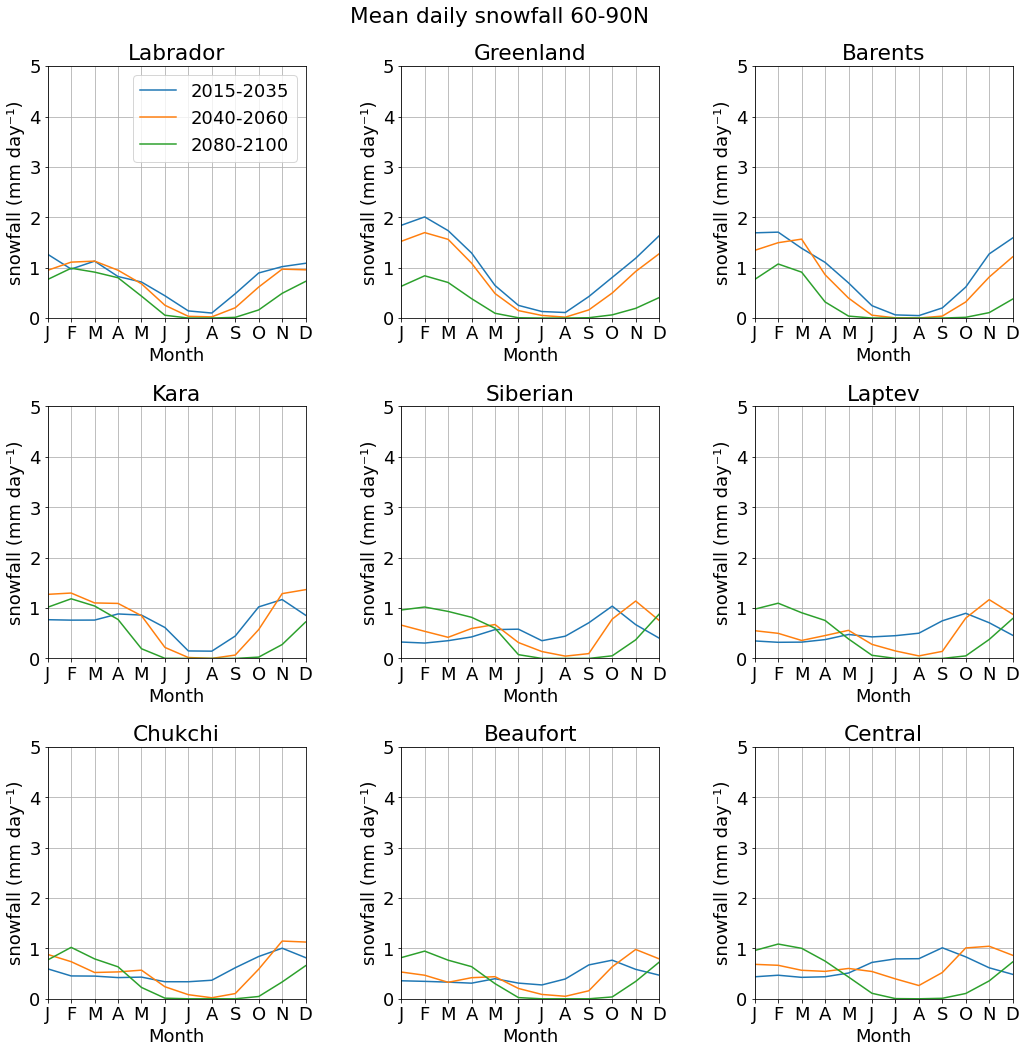

In [6]:
libs.plot.monthly_variability_regional(
    prsn, 
    title='Mean daily snowfall 60-90N', 
    ylabel='snowfall (mm day⁻¹)',
    process=lambda x: helpers.monthly_means_time(x * 86400),
    ylim=[0, 5]
)

### Regional rainfall

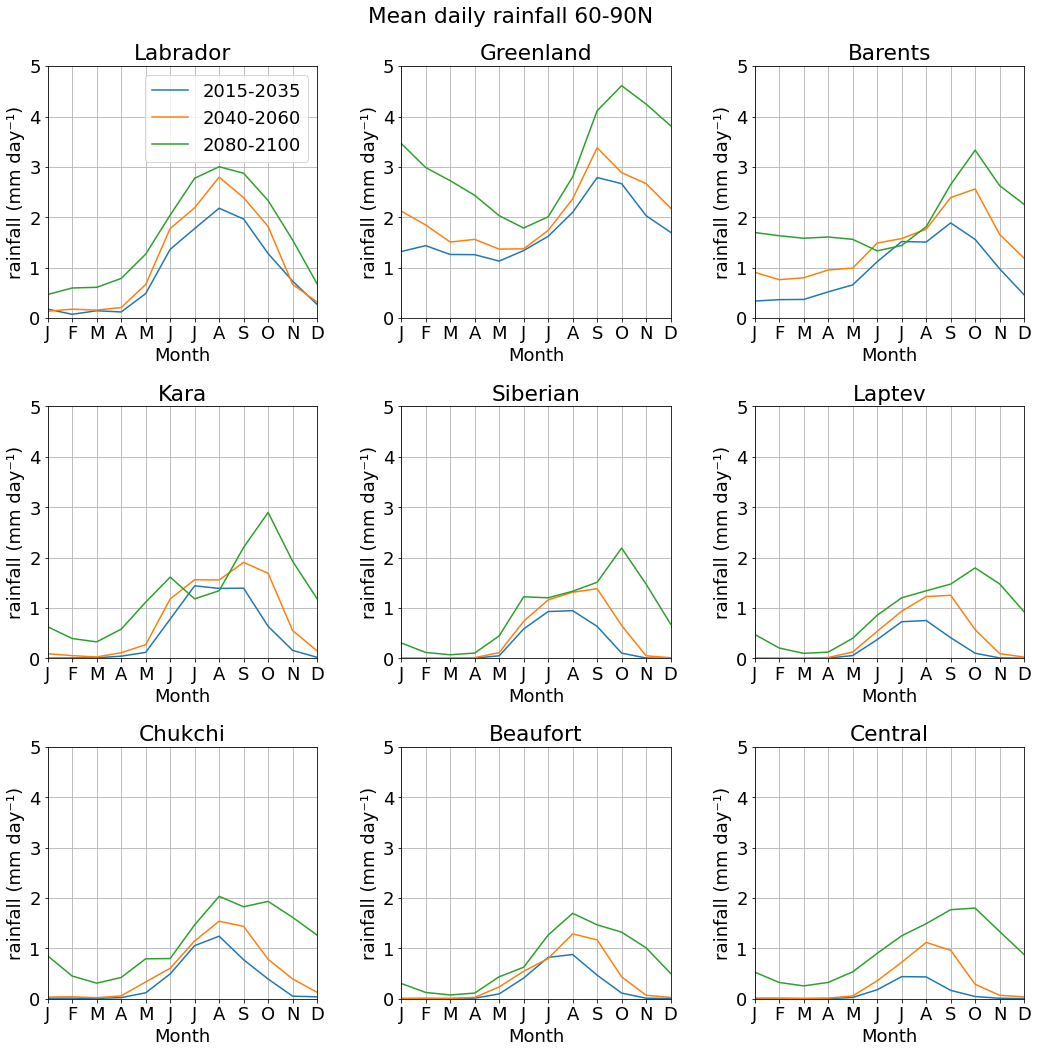

In [7]:
libs.plot.monthly_variability_regional(
    prra, 
    title='Mean daily rainfall 60-90N', 
    ylabel='rainfall (mm day⁻¹)',
    process=lambda x: helpers.monthly_means_time(x * 86400),
    ylim=[0, 5]
)

## Seasonal variability (spatial)

In [8]:
def plot_season(arr, s, vmin, vmax):
    for item in arr:
        data_mod = helpers.seasonal_means_spatial(item['data'].copy() * 86400, s)
        label = item['label']
        units = 'mm day⁻¹'

        libs.plot.nstereo(
            data_mod,
            title=f'{s} SSP585 mean daily {(label).lower()} over ocean & sea ice 60-90°N ({units})',
            colorbar_label=f'{label} ({units})',
            colormesh_kwargs={
                'extend': 'max',
                'vmin': vmin,
                'vmax': vmax
            }
        )

### MAM

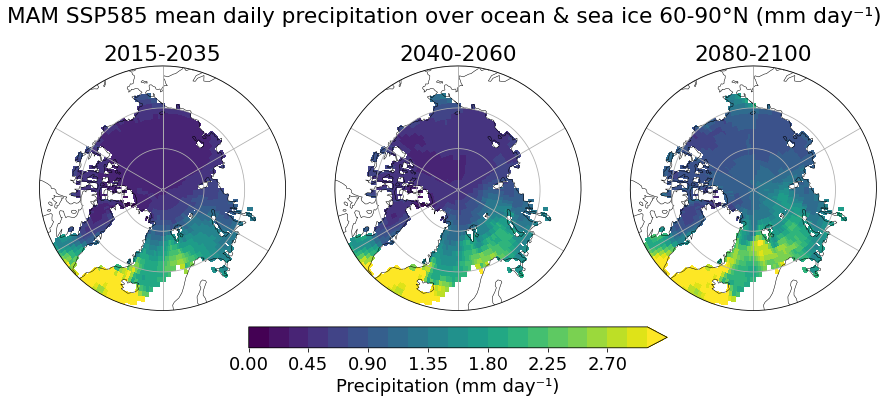

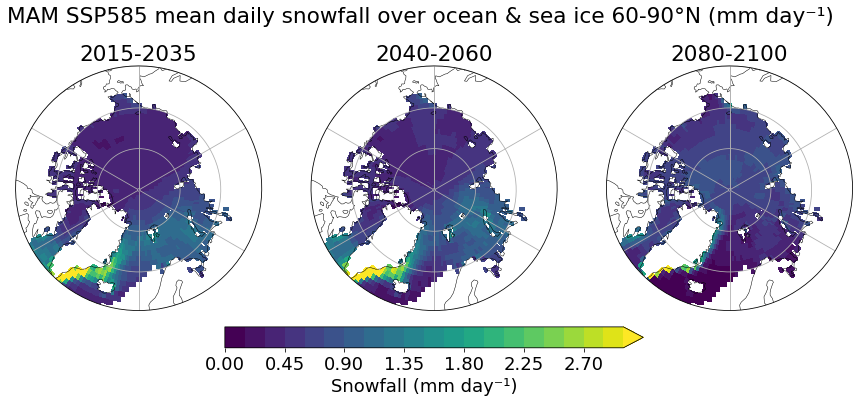

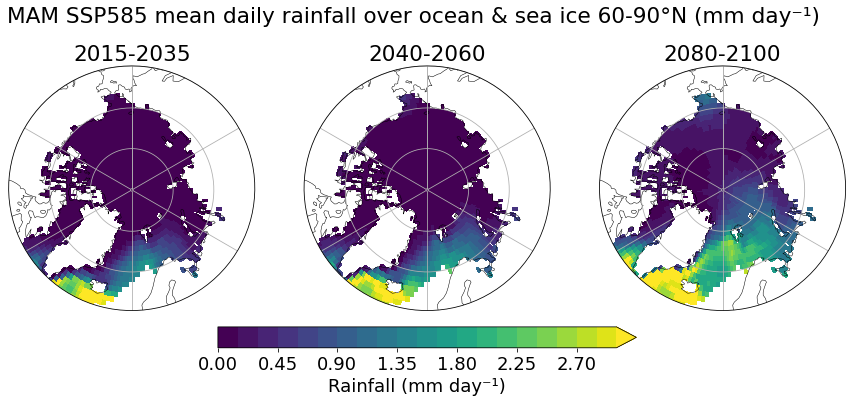

In [9]:
plot_season(pr_arr, 'MAM', 0, 3)

### JJA

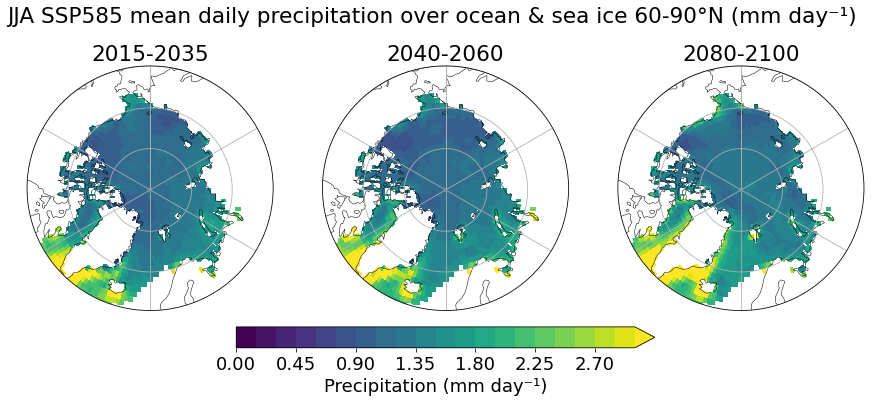

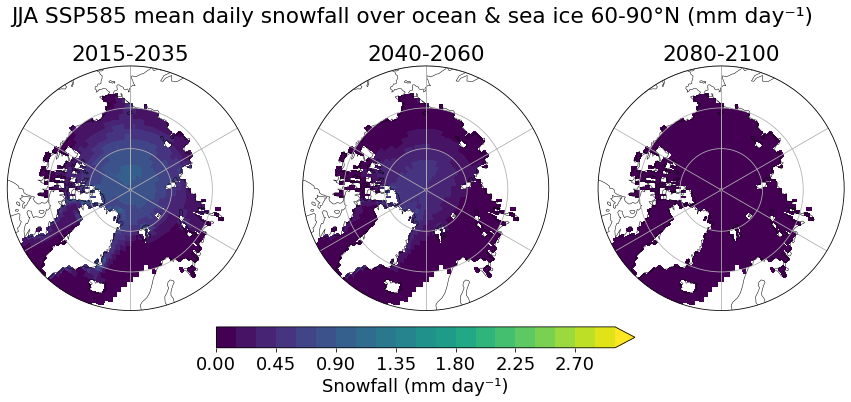

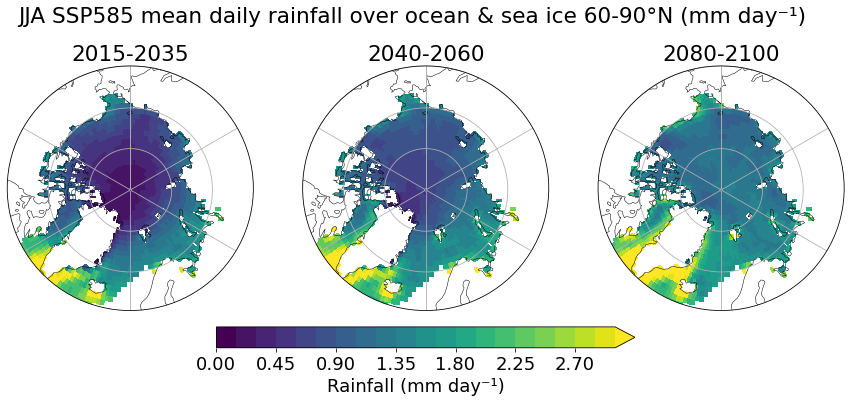

In [10]:
plot_season(pr_arr, 'JJA', 0, 3)

### SON

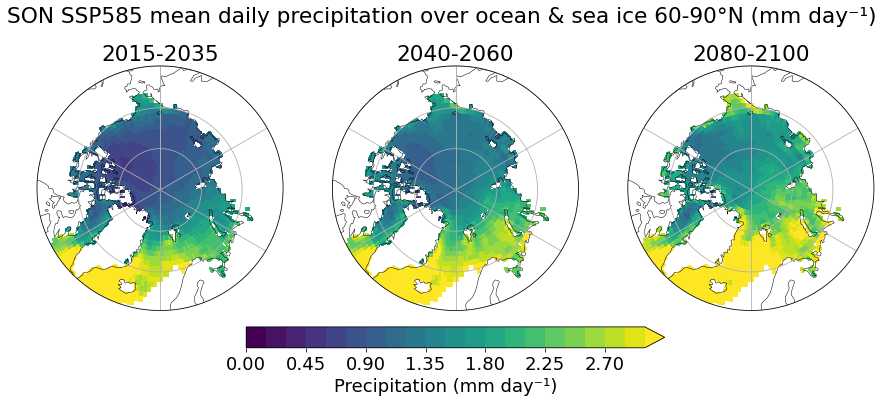

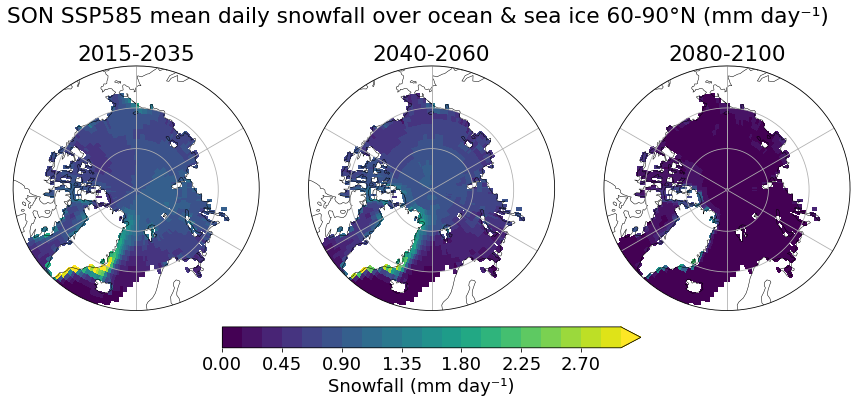

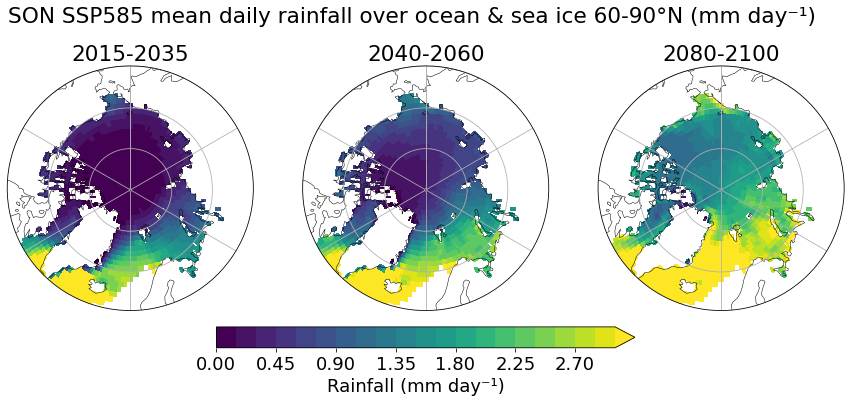

In [11]:
plot_season(pr_arr, 'SON', 0, 3)

### DJF

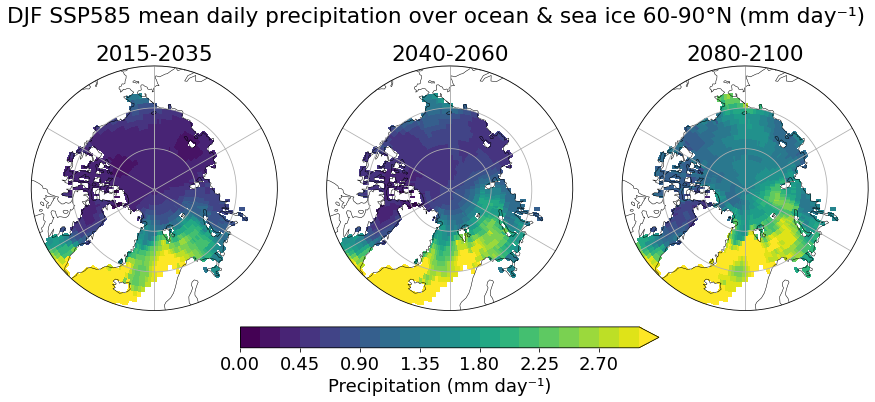

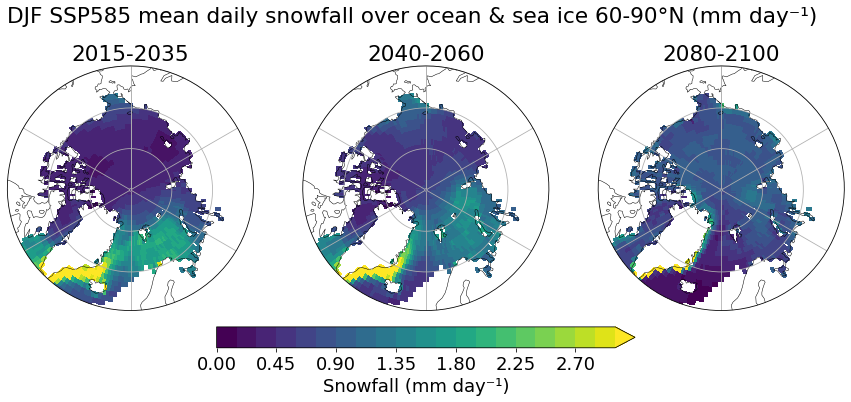

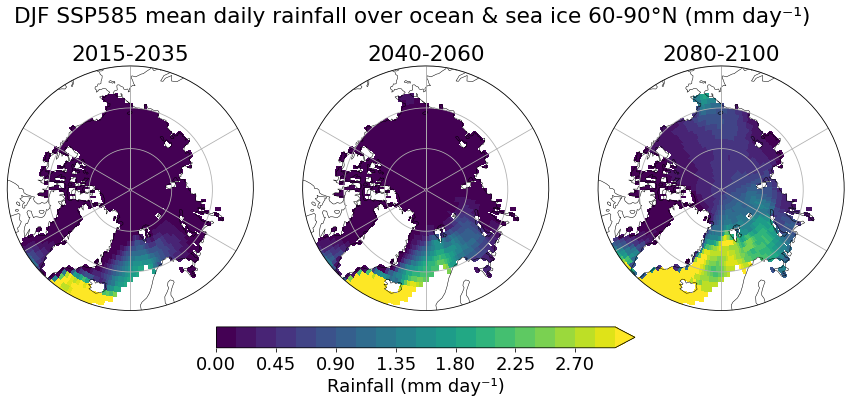

In [12]:
plot_season(pr_arr, 'DJF', 0, 3)